## XGBoost Toolbox

In [1]:
import numpy as np
import pandas as pd
import arff
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
#plt.style.use('ggplot') 

%matplotlib inline

### Data load and transformation

In [2]:
def label_dist(df,label):
    plt.figure(figsize=(40,20))
    plt.xticks(fontsize=24, rotation=0)
    plt.yticks(fontsize=24, rotation=0)
    sns.countplot(data=df, x='Snore')

def arff_to_df_to_matrix (X,drop,label,hot_encode=False):
    # arff handle
    data = arff.load(open(X))
    header = [d[0] for d in data['attributes']]
    df = pd.DataFrame.from_records(data['data'], columns=header)
    df = df.drop(drop, axis=1)
    col_no = df.shape[1] - 1
    
    label_dist(df,label)
    
    if hot_encode:
        #one-hot target labels
        df = pd.get_dummies(df, columns=[label])
    else:
        df[label] = pd.Categorical(df[label])
        df[label] = df[label].cat.codes

    header = list(df)
    X_header = header[:col_no]
    y_header = header[col_no:]    
    X = df.as_matrix(columns=X_header)
    y = df.as_matrix(columns=y_header)
    
    print("Targets: {}",y_header)
    #print("Data: {}",X_header)
    
    return df, X, y

Targets: {} ['Snore']


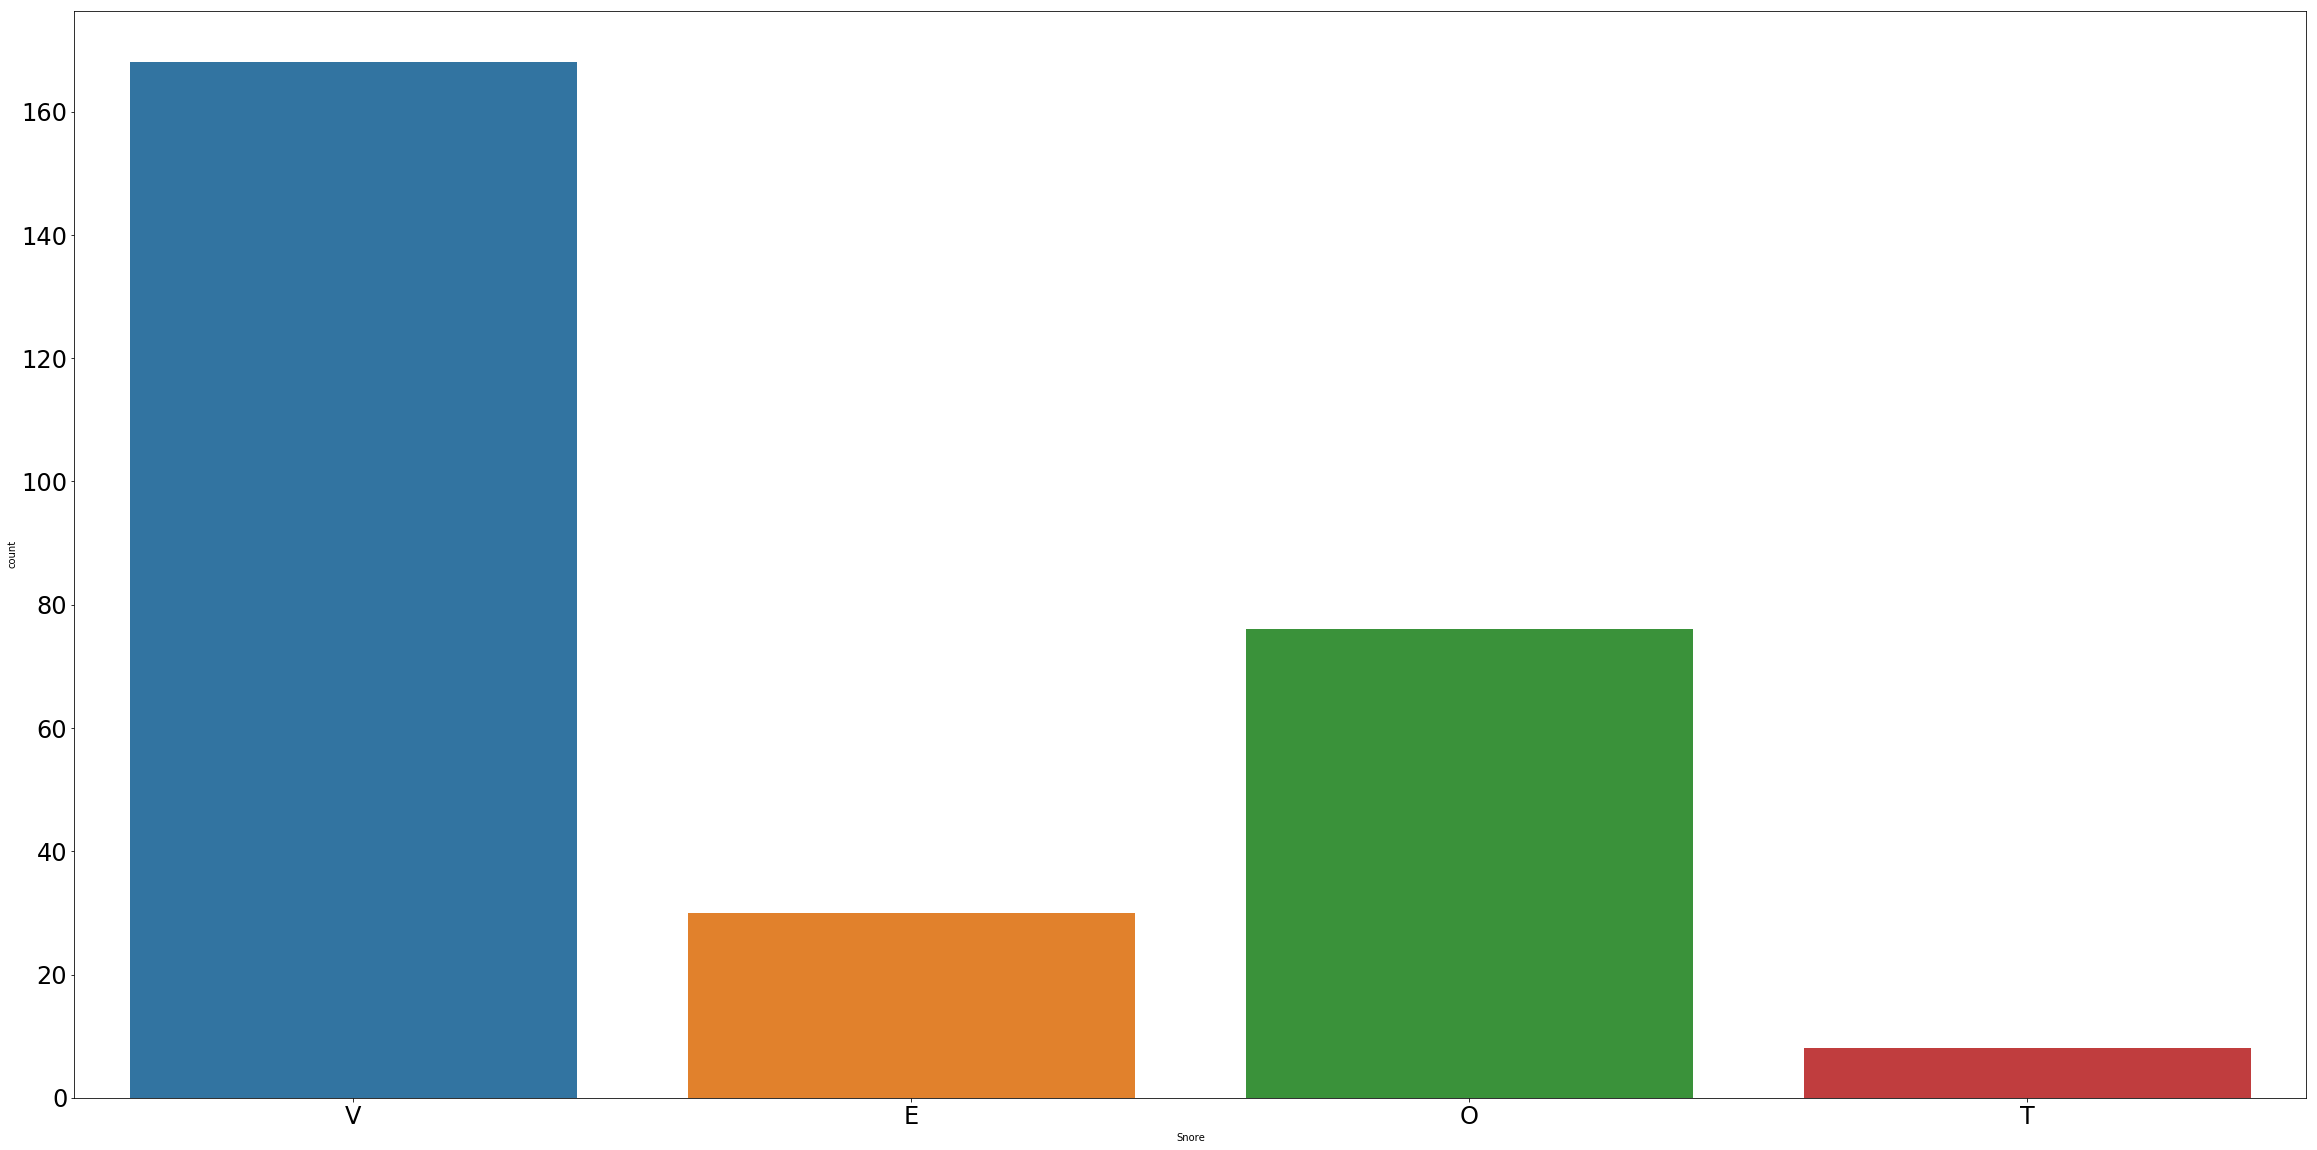

In [3]:
#Train
X_y_train, X_train, y_train = arff_to_df_to_matrix('ComParE2017_Snore.ComParE.train.arff'
                                                   ,drop=['name']
                                                   ,label='Snore')

In [4]:
display(X_y_train.head())
display(X_train[0])
display(y_train[0])

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,pcm_fftMag_mfcc_sma_de[14]_peakRangeRel,pcm_fftMag_mfcc_sma_de[14]_peakMeanAbs,pcm_fftMag_mfcc_sma_de[14]_peakMeanMeanDist,pcm_fftMag_mfcc_sma_de[14]_peakMeanRel,pcm_fftMag_mfcc_sma_de[14]_minRangeRel,pcm_fftMag_mfcc_sma_de[14]_meanRisingSlope,pcm_fftMag_mfcc_sma_de[14]_stddevRisingSlope,pcm_fftMag_mfcc_sma_de[14]_meanFallingSlope,pcm_fftMag_mfcc_sma_de[14]_stddevFallingSlope,Snore
0,0.655510,0.626263,0.171717,1.489846,1.679704,1.725918,0.189858,0.046214,0.236072,1.180407,...,0.450374,1.245731,1.202798,16.01042,0.491986,75.82991,34.17194,61.91931,43.14025,3
1,1.668499,0.673469,0.918367,0.664837,0.945646,1.121034,0.280808,0.175388,0.456196,0.546162,...,0.505948,1.156657,1.123304,16.71507,0.410738,64.47056,31.48577,54.33904,24.79349,3
2,0.496206,0.500000,0.130952,1.233464,1.388136,1.452365,0.154672,0.064229,0.218901,1.126269,...,0.575709,1.563734,1.560372,19.99418,0.470473,85.05767,50.14820,94.07275,37.97345,0
3,0.860759,0.615942,0.000000,0.726566,1.126375,1.276043,0.399809,0.149668,0.549477,0.673100,...,0.507177,1.217330,1.198180,18.55790,0.526939,66.79765,34.70250,59.91121,30.91694,3
4,0.983058,0.671329,0.965035,0.861250,1.047830,1.257373,0.186579,0.209543,0.396122,0.605830,...,0.554339,1.471303,1.407281,14.98888,0.562487,87.94997,33.17284,94.32734,48.24079,0


array([ 0.6555096,  0.6262626,  0.1717172, ..., 34.17194  , 61.91931  ,
       43.14025  ])

array([3], dtype=int8)

Targets: {} ['Snore']


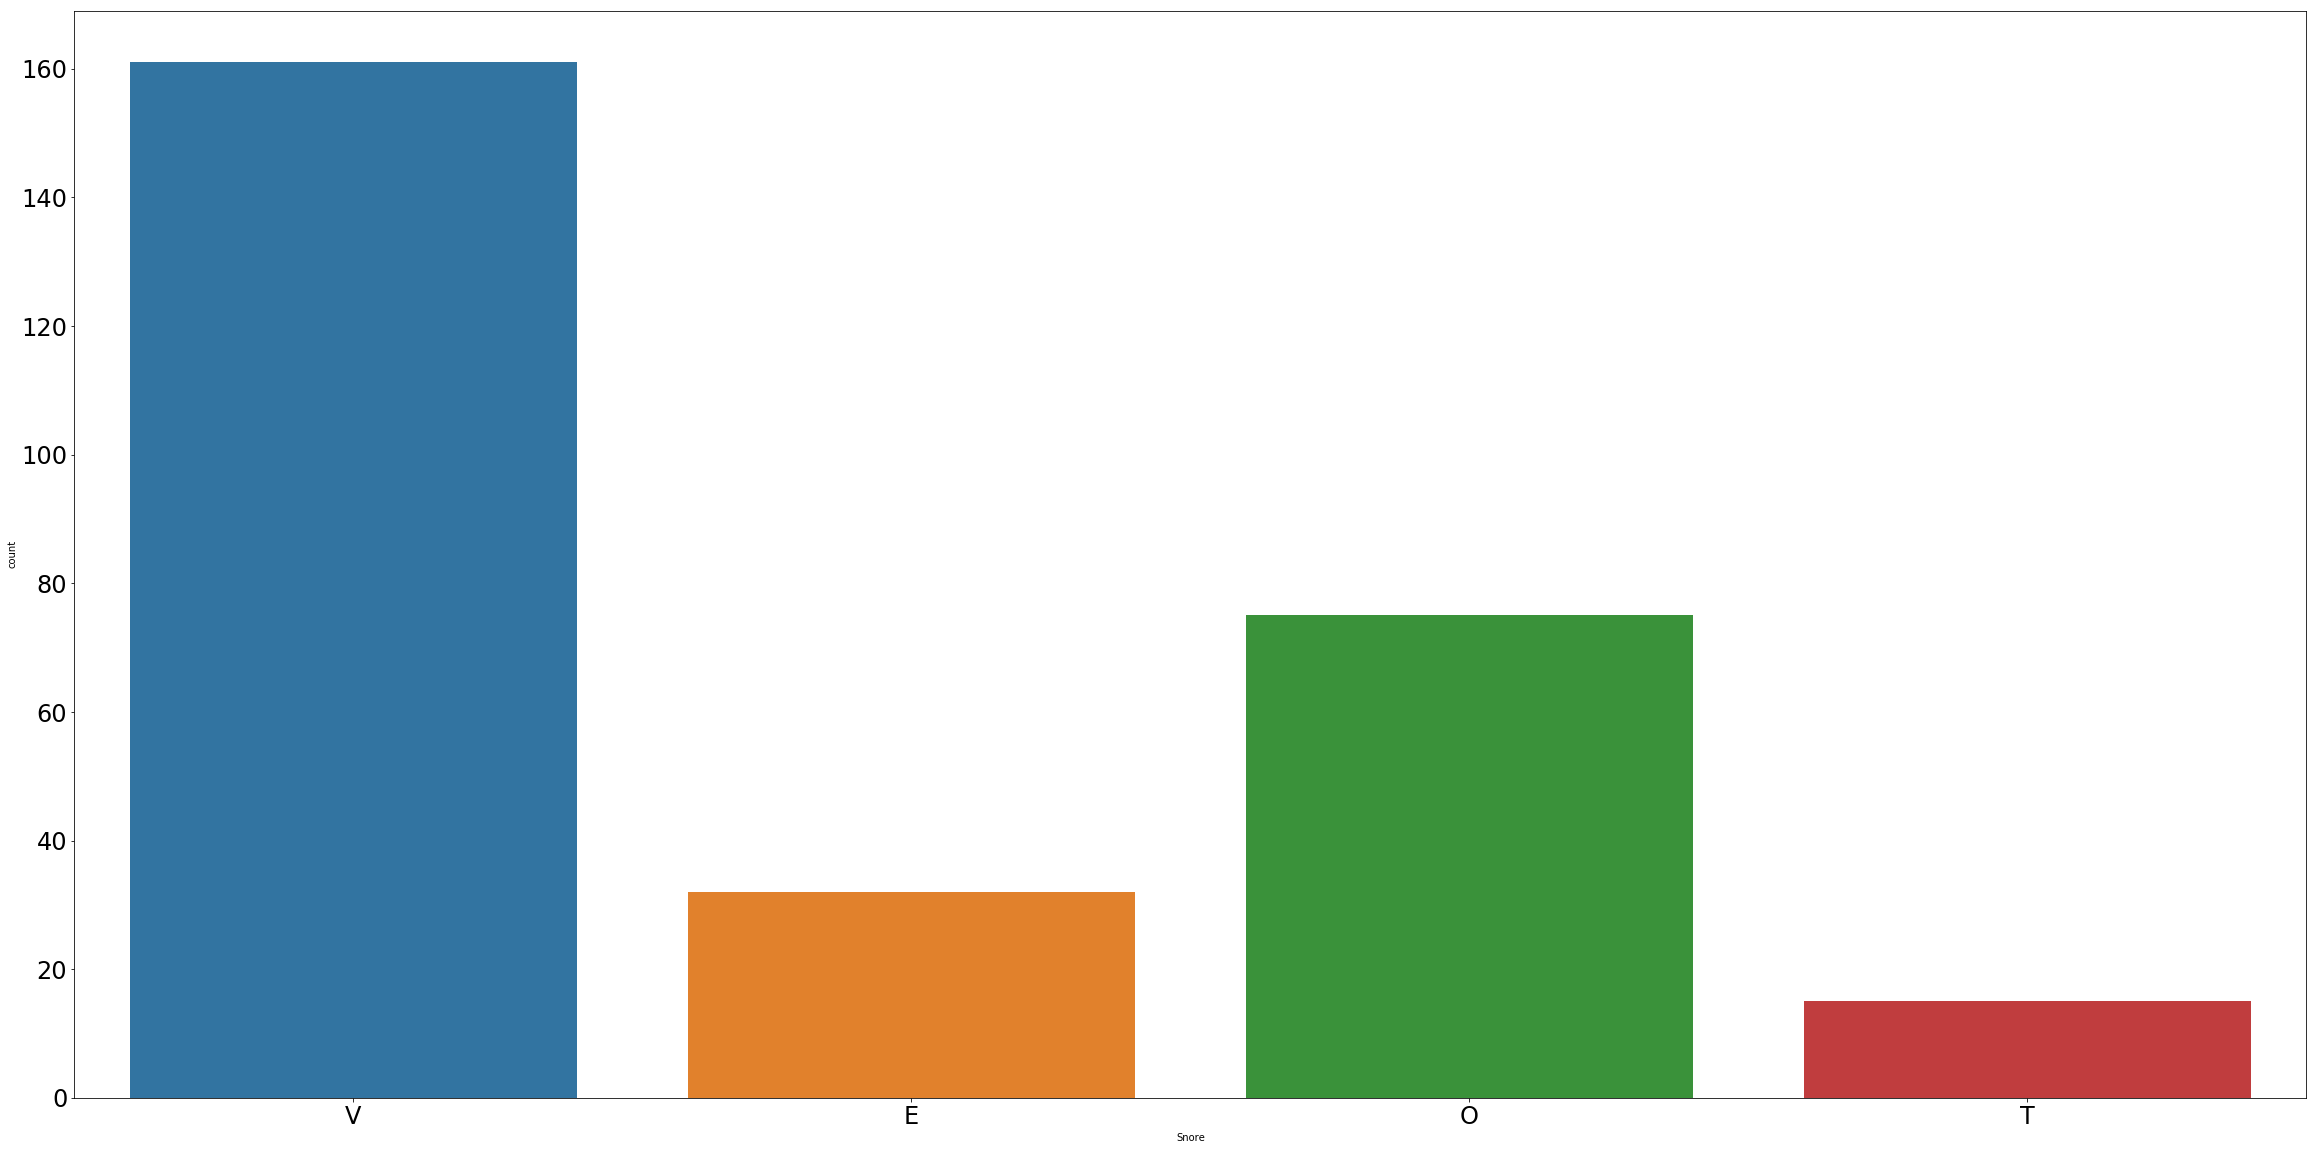

In [5]:
#Val
X_y_val, X_val, y_val = arff_to_df_to_matrix('ComParE2017_Snore.ComParE.devel.arff'
                                                ,drop=['name']
                                                ,label='Snore')

#### "Balance" every class by assigning weights for cost function

In [7]:
def weighting(y,hot_encode=False, w=[]):
    if hot_encode:
        #Parse back hot-encode matrix to int array to keep it clean
        y = np.argmax(y, axis=1)
    
    weights = []
    for label in np.unique(y):
        weights.append(1 - float(np.sum(y == label))/len(y))
    
    if len(w) > 1:
        weights = w
    
    print("Weighting:",weights)
    w = np.zeros(len(y))
    
    for class_idx in range(len(weights)):
        weight = weights[class_idx]
        for v in range(len(y)):
            if y[v] == class_idx:
                w[v] = weight
    
    return w

### Selection of weights - execute only one!

In [8]:
# with weights
xg_train = xgb.DMatrix(X_train, label=y_train, weight = weighting(y_train))
xg_val = xgb.DMatrix(X_val, label=y_val)

Weighting: [0.8936170212765957, 0.7304964539007093, 0.9716312056737588, 0.4042553191489362]


In [11]:
# with manual engineered weights
xg_train = xgb.DMatrix(X_train, label=y_train, weight = weighting(y_train,w=[0.5, 0.1, 2.9, 0.12]))
xg_val = xgb.DMatrix(X_val, label=y_val)

Weighting: [0.5, 0.1, 2.9, 0.12]


In [10]:
# OR without weights
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_val = xgb.DMatrix(X_val, label=y_val)

### Training XGBoost

In [12]:
# setup parameters for xgboost
# 'objective': 'multi:softprob',  # error evaluation for multiclass training
# eta 0.1, 0.2, 0.3
# max_depth: 2,3,6
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softmax',
    'nthread': 4,
    'num_class': 4, # the number of classes that exist in this datset
    'eval_metric': 'merror'} 

watchlist = [(xg_train, 'train'), (xg_val, 'val')]
num_round = 125
bst = xgb.train(param, xg_train, num_round, watchlist)

[0]	train-merror:0.057611	val-merror:0.448763
[1]	train-merror:0.048211	val-merror:0.477032
[2]	train-merror:0.041844	val-merror:0.4947
[3]	train-merror:0.038811	val-merror:0.480565
[4]	train-merror:0.032747	val-merror:0.466431
[5]	train-merror:0.030928	val-merror:0.491166
[6]	train-merror:0.027289	val-merror:0.473498
[7]	train-merror:0.02547	val-merror:0.480565
[8]	train-merror:0.02547	val-merror:0.452297
[9]	train-merror:0.023651	val-merror:0.448763
[10]	train-merror:0.022135	val-merror:0.45583
[11]	train-merror:0.018496	val-merror:0.441696
[12]	train-merror:0.018496	val-merror:0.431095
[13]	train-merror:0.01698	val-merror:0.434629
[14]	train-merror:0.01698	val-merror:0.431095
[15]	train-merror:0.01698	val-merror:0.427562
[16]	train-merror:0.01698	val-merror:0.434629
[17]	train-merror:0.013645	val-merror:0.424028
[18]	train-merror:0.013645	val-merror:0.424028
[19]	train-merror:0.013645	val-merror:0.427562
[20]	train-merror:0.012129	val-merror:0.424028
[21]	train-merror:0.012129	val-m

In [13]:
#Unweighted Average Recall (UAR) = mean(R1, R2)
from sklearn.metrics import recall_score, accuracy_score
def evaluate(y_true, y_pred):
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print('UAR: ', recall_score(y_true, y_pred, average='macro'))
    df_confusion = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    df_confusion = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    display(df_confusion)
    display(df_confusion / (df_confusion.sum(axis=1) /2))
    return y_true != y_pred

evaluate(np.hstack(y_train),bst.predict(xg_train).astype(int))
print('Valuation:')
fail = evaluate(np.hstack(y_val),bst.predict(xg_val).astype(int))


Accuracy:  1.0
UAR:  1.0


Predicted,0,1,2,3,All
Actual,,,,,
0,30,0,0,0,30
1,0,76,0,0,76
2,0,0,8,0,8
3,0,0,0,168,168
All,30,76,8,168,282


Predicted,0,1,2,3,All
Actual,,,,,
0,1.0,0.0,0.0,0.0,0.106383
1,0.0,1.0,0.0,0.0,0.269504
2,0.0,0.0,1.0,0.0,0.028369
3,0.0,0.0,0.0,1.0,0.595745
All,1.0,1.0,1.0,1.0,1.000000


Valuation:
Accuracy:  0.6325088339222615
UAR:  0.4340120341614907


Predicted,0,1,2,3,All
Actual,,,,,
0,11,7,0,14,32
1,0,32,0,43,75
2,3,8,2,2,15
3,0,26,1,134,161
All,14,73,3,193,283


Predicted,0,1,2,3,All
Actual,,,,,
0,0.34375,0.093333,0.000000,0.086957,0.113074
1,0.00000,0.426667,0.000000,0.267081,0.265018
2,0.09375,0.106667,0.133333,0.012422,0.053004
3,0.00000,0.346667,0.066667,0.832298,0.568905
All,0.43750,0.973333,0.200000,1.198758,1.000000


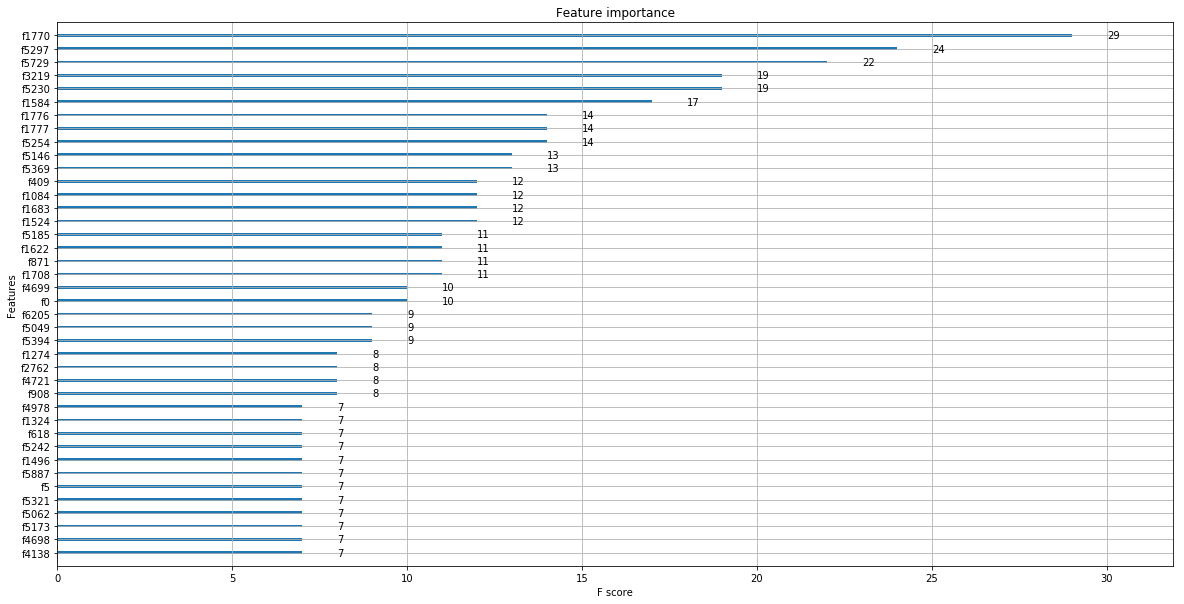

In [14]:
def my_plot_importance(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgb.plot_importance(booster=booster, ax=ax, max_num_features=40, **kwargs)

my_plot_importance(bst,(20,10))

### Scoring Test set
#### dataset not deep, concat for more variance

In [15]:
#concat training und validation
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

In [17]:
# with weights
xg_train_val = xgb.DMatrix(X_train_val, label=y_train_val, weight = weighting(y_train_val))

num_round = 40
bst = xgb.train(param, xg_train_val, num_round, watchlist)

Weighting: [0.8902654867256637, 0.7327433628318585, 0.95929203539823, 0.41769911504424784]
[0]	train-merror:0.142207	val-merror:0.14841
[1]	train-merror:0.129776	val-merror:0.155477
[2]	train-merror:0.074894	val-merror:0.144876
[3]	train-merror:0.067617	val-merror:0.141343
[4]	train-merror:0.061856	val-merror:0.127208
[5]	train-merror:0.061856	val-merror:0.120141
[6]	train-merror:0.05852	val-merror:0.088339
[7]	train-merror:0.053669	val-merror:0.095406
[8]	train-merror:0.058217	val-merror:0.084806
[9]	train-merror:0.05185	val-merror:0.067138
[10]	train-merror:0.053669	val-merror:0.063604
[11]	train-merror:0.053669	val-merror:0.060071
[12]	train-merror:0.053366	val-merror:0.060071
[13]	train-merror:0.05185	val-merror:0.045936
[14]	train-merror:0.05185	val-merror:0.038869
[15]	train-merror:0.006367	val-merror:0.028269
[16]	train-merror:0.008187	val-merror:0.028269
[17]	train-merror:0.006671	val-merror:0.024735
[18]	train-merror:0.004851	val-merror:0.017668
[19]	train-merror:0.004851	val-

In [18]:
def arff_to_df_to_matrix_test (X,drop,hot_encode=False):
    # arff handle
    data = arff.load(open(X))
    header = [d[0] for d in data['attributes']]
    df = pd.DataFrame.from_records(data['data'], columns=header)
    df = df.drop(drop, axis=1)
    col_no = df.shape[1] - 1
    header = list(df)
    X_header = header[:col_no]   
    X = df.as_matrix(columns=X_header)
    return df, X

#Test not working because of missing labels (hold back?)
X_y_test, X_test = arff_to_df_to_matrix_test('ComParE2017_Snore.ComParE.test.arff'
                                                ,drop=['name'])
xg_test = xgb.DMatrix(X_test)

print(bst.predict(xg_test).astype(int))

[1 1 3 1 3 0 3 3 3 3 3 3 3 3 1 3 0 3 1 0 1 3 3 3 1 0 3 1 3 1 3 3 3 3 0 3 1
 3 0 3 1 1 1 3 3 0 0 3 1 0 1 3 0 1 3 3 0 0 1 1 0 1 3 0 0 1 3 3 3 3 0 3 3 3
 0 3 3 3 3 3 1 3 1 0 3 3 3 1 1 3 3 3 3 3 3 3 3 3 3 3 1 3 3 0 1 3 1 1 3 3 3
 1 0 1 1 3 1 3 3 3 1 3 3 3 3 3 3 3 0 3 3 0 0 3 3 3 3 3 1 3 3 3 3 1 3 0 3 1
 3 3 1 3 1 3 3 0 3 3 3 0 3 1 1 3 3 1 1 3 3 1 3 3 3 3 1 0 0 3 1 3 3 3 0 3 0
 1 3 1 3 1 3 3 3 1 3 3 3 3 1 3 1 3 3 1 3 3 1 0 3 3 3 3 3 1 0 3 3 3 3 1 3 3
 3 1 3 0 0 0 1 1 3 0 3 3 3 3 3 3 0 3 3 0 1 3 3 3 0 3 1 3 0 3 3 1 3 1 1 3 3
 1 1 3 3]


#### Compress and export trained model

In [ ]:
joblib.dump(bst, 'bst_model.pkl', compress=True)